### Altimeter Setting - Spatiotemporal Analysis

This notebook demonstrates how spatial kriging analyses, generated independently in time, can be combined into
spatial-temporal analyses using the Kalman (Rauch–Tung–Striebel: RTS) Smoother. Specifically, at each grid point a kriging analysis
and variance estimate is used to initialize a Kalman Filter which provides smoothed estimates of the time-series over a fixed-window.
Since the Kalman filter can approximate non-linear processes over short-time periods, this fixed window is limited to two hours. Overlapping
windows are used to generate continuous smoothed time-series at every grid point. The result: a spatiotemporal analysis of the analysis variable
that is consistent in space & time.

1) Functions for extracting time-series from LatticeKrig analyses and smoothing time-series using the RTS smoother are provided

2) The fixed-lag smoothing approach is employed over a 2-hr window. Kalman smoothing and time series analysis is performed at three verification sites located in an urban, suburban, and rural environments.

3) A sliding 2-hr window is used to generate smoothed time-series at hourly intervals which are then combined. This approach ensures spatio-temporal analysis are consistent between each time-window. Pressure time-series verification is performed at the METAR sites from (2). Time-series are also detrended to evaluate the effect of Kalman smoothing on the relative accuracy of pressure analyses.

In [1]:
#---- (1) ---- #

#Import Python libraries
import os
import sys
sys.path.append('../../../PyScripts')
import xarray as xr
import matplotlib
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import funcs
import colorcet as cc
from datetime import datetime,timedelta
from cartopy.feature import NaturalEarthFeature,BORDERS,LAKES,COLORS
import cartopy.crs as crs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from filterpy.kalman import KalmanFilter
from numpy import random
from numpy.random import randn
from sklearn.metrics import mean_squared_error,mean_absolute_error
from scipy import signal

#Retrieve perceptually uniform colorbar from colorcet
cmapp = cc.cm.rainbow_bgyrm_35_85_c71

#Set format for datetime objects
fmt = '%Y%m%d_%H%M'

# Download/add state and coastline features for cartopy 
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
land_50m = NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='none')

#Increase with of notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Set matplotlib base fontsize
matplotlib.rcParams.update({'font.size': 16})
#Define variable
otyp='altimeter'

#Define function to perform Kalman smoothing from grid-point time-series of pressure
def kf_smooth(vvar_ts, vvar_ts_var, mdts, malts, mlat, mlng, sid, dts, plot):
    noise = 1; Q = np.mean(vvar_ts_var)
    xinit = vvar_ts[0]; dxinit = vvar_ts[1]-vvar_ts[0]

    fk = KalmanFilter(dim_x=2, dim_z=1)   # First order Kalman Filter
    fk.x = np.array([xinit, dxinit])      # state (x and dx)
    fk.F = np.array([[1., 1.],
                 [0., 1.]])        # state transition matrix
    fk.H = np.array([[1., 0.]])    # Measurement function
    fk.P = 1.                      # covariance matrix
    fk.R = noise                   # state uncertainty
    fk.Q = Q                       # process uncertainty

    # filter data with Kalman filter, than run smoother on it
    mu, cov, _, _ = fk.batch_filter(vvar_ts)
    # Perform kalman smoothing
    M, P, C, _ = fk.rts_smoother(mu, cov)

    #If True: display a plot showing a time-series of unmodified, kalman filtered, and smoothed Kriging analyses
    if (plot):
        index = 0
        
        #Set Y-axis limits for plot using min/max altimeter from observed and grid-point time-series
        mmin = round(np.array([malts.min(),(vvar_ts-0.5*np.sqrt(vvar_ts_var)).min()]).min() - 0.5,0)
        mmax = round(np.array([malts.max(),(vvar_ts+0.5*np.sqrt(vvar_ts_var)).max()]).max() + 0.5,0)
        
        #Plot figure
        fig = plt.figure(figsize=(20,8))
        #Time-series of altimeter setting from LatticeKrig
        plt.plot(dts,vvar_ts,c='k',label='LK Altimeter',lw=3) 
        #Shade region of uncertainty (+/- one standard deviation of altimeter setting, derived from LatticeKrig conditional simulations)
        plt.fill_between(dts,vvar_ts - vvar_ts_var,vvar_ts + vvar_ts_var,color='grey',alpha=0.5,label='LK Prediction Error')
        #Smoothed altimeter time-series
        plt.plot(dts,M[:, index], c='forestgreen', lw=3,label='Rauch–Tung–Striebel (RTS) Smoother') 
        #Kalman filter estimate of pressure time-series 
        plt.plot(dts,mu[:, index], c='orangered', ls='--', lw=3,label='Kalman Filter') 
        #Observed pressure time series from METAR station
        plt.plot(mdts,malts,'ok',c='hotpink',lw=3,ms=15,markeredgecolor='k',label='Observed')
        #Set plot title (include lat/lng)
        plt.title('Altimeter Time-Series Analysis at '+sid+': ('+str(mlat)+','+str(mlng)+')',fontsize=20)
        plt.grid(True)
        #Show analysis window (only data between these two bars is used).
        plt.axvline(x=dts[6],color='gray',lw=2,ls='-.',label='Analysis Window')
        plt.axvline(x=dts[18],color='gray',lw=2,ls='-.')
        #Label X/Y axis and plot legend
        plt.xlabel('Time (UTC)')
        plt.xticks(rotation=45)
        plt.legend(loc='best',ncol=2,numpoints=1)
        plt.xlim([dts[0],dts[-1]])
        plt.ylim([mmin,mmax])
        plt.ylabel('Altimeter (hPa)')
        plt.tight_layout()
        plt.show()

    #Return Kalman smoothed time-series and Kalman Filtered time-series
    return M[:,0],mu[:,0]

#Retrieve pressure time series from grid point closest to the selected latitude/longitude
def extract_point(ds,otyp,lat,lng):
    X,Y = ds['longitude'].values,ds['latitude'].values
    
    #Find index of lat/lng closest to requested position
    xi = abs(X-lng).argmin()
    yi = abs(Y-lat).argmin()

    #Extract time-series from 3D (time,latitude,longitude) xarray dataset
    ds = ds.isel(latitude=yi)
    ds = ds.isel(longitude=xi)

    #Retrieve the estimate (altimeter) and uncertainty (prediction error estimate)
    vvar = ds[otyp].values
    vvar_var = ds[otyp+'_var'].values
    return vvar,vvar_var 

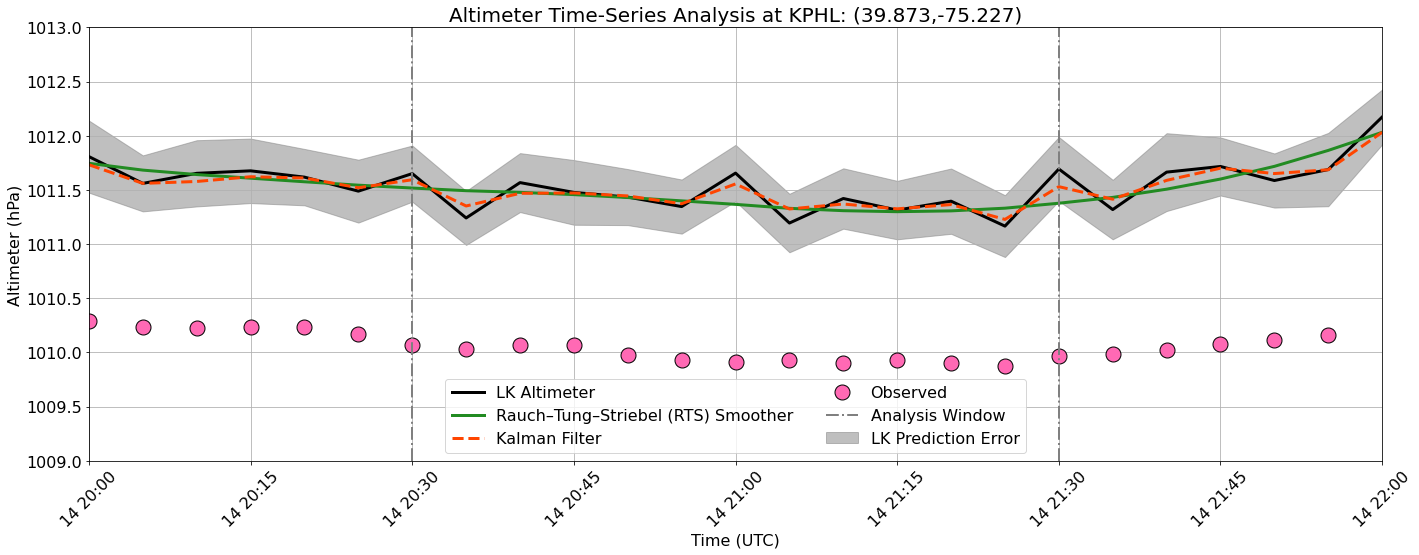

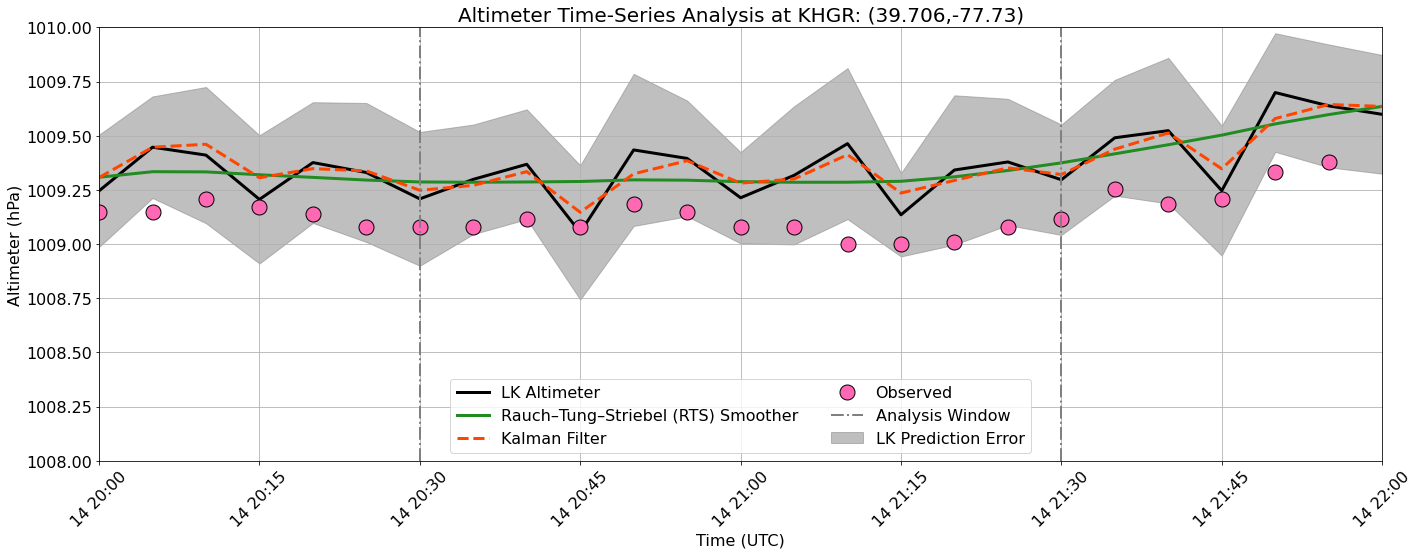

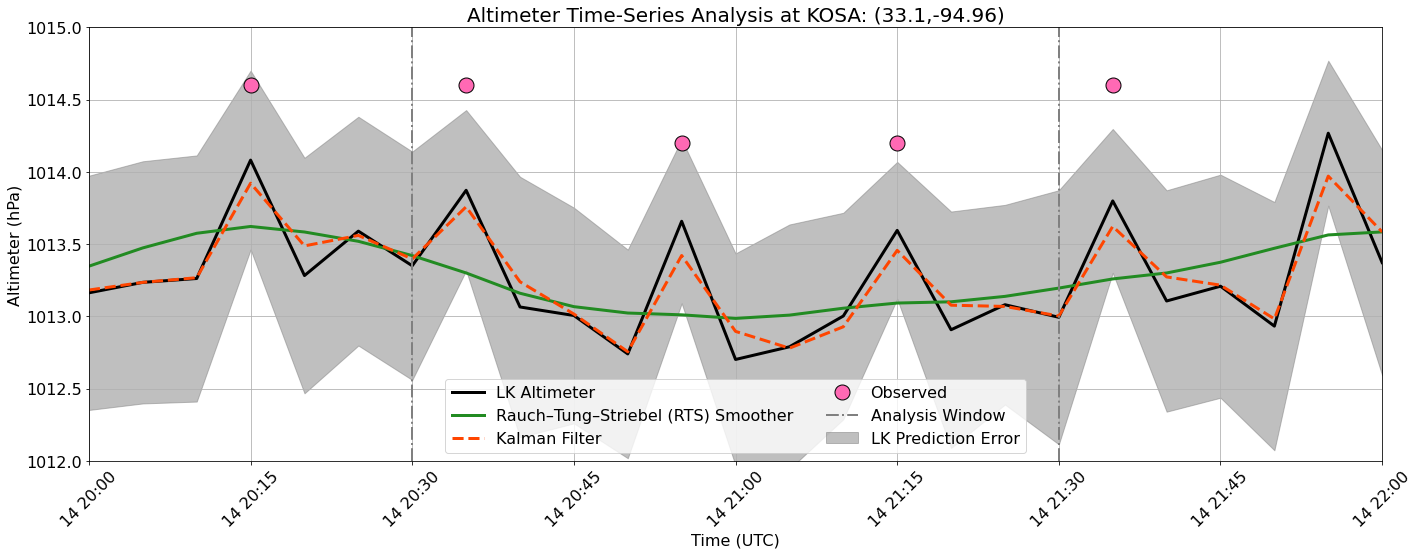

In [2]:
#---- (2) ---#

#Define start and end date for Kalman smoothing (performed over two-hour window)
dstart = '20180414_2000'
dend = '20180414_2200'
        
#Define function to retrieve and plot kalman smoothed time-series at grid points nearest METAR verification sites.
def get_kf_sid(dstart,dend,sid,plot=True):

    #Get list of dates (every 5-min) between start and end time
    dtlist = funcs.date_list(dstart,dend,300,fmt)
    
    #Convert date string list to list of datetime objects
    dts_sub = funcs.to_dt(dtlist,fmt)
    
    #Retrieve pre-generated LatticeKrig analyses
    ds_all = []
    for date in dtlist:
        ds = xr.open_dataset('../../../../data/FRK/frkmadis_full_altimeter_'+date+'.nc')
        ds_all.append(ds)
        ds.close()

    #Concatenate datsets to form 3D dataset (Time,latitude,longitude)
    ds_all = xr.concat(ds_all,'Valid')
    ds_all['Valid'] = xr.DataArray(dts_sub,coords={'Valid':np.arange(0,len(dts_sub))},dims=('Valid'))

    #Retrieve METAR verification data from selection station
    ds_ob = xr.open_dataset('../../../../data/METAR/'+sid+'.nc')
    epoch = ds_ob['Valid'].values

    #Subset verification time-series to analysis window (dstart - dend)
    sti = np.argmin(abs(epoch-np.datetime64(dts_sub[0])))
    eti = np.argmin(abs(epoch-np.datetime64(dts_sub[-1])))
    ds_ob = ds_ob.isel(Valid=np.arange(sti,eti))
    
    #Round latitude/longitude for title
    lat = np.round(ds_ob['latitude'].values,3)
    lng = np.round(ds_ob['longitude'].values,3)
    
    #Retrive verification observation data
    mdts = ds_ob['Valid'].values
    malts = ds_ob['altimeter'].values

    #Extract pressure analysis time-series at specified point
    vvar_ts,vvar_var_ts = extract_point(ds_all,otyp,lat,lng)
    
    #Perform kalman smoothing of pressure time-series 
    rts,kf = kf_smooth(vvar_ts,vvar_var_ts,mdts,malts,lat,lng,sid,dts_sub,plot)

    #If not generating plot, return data
    if (plot==False):
        return dts_sub,vvar_ts,vvar_var_ts,kf,rts

    
#Perform Kalman smoothing and Time-series analysis at three unique verification sites (all of which were included in the kriging analysis)

#Urban Site
get_kf_sid(dstart,dend,"KPHL",True)

#Suburban Site
get_kf_sid(dstart,dend,'KHGR',True)

#Rural Site
get_kf_sid(dstart,dend,"KOSA",True)

The figures generated in (2) demonstrate the noise inherent in spatial kriging analyses produced by LatticeKrig. This noise is a consequence of the variable observation frequency and thus variable observation density of in situ MADIS pressure observations. Every 5-min a different subset of MADIS observations are contributing to kriging analyses. Automated Weather Observing Stations (AWOS) sites report every 20-minutes and provide a wealth of data at rural airports across the U.S. This is in contrast to ASOS and Mesonet observations which typically provide pressure observations every 5-minutes. This diference in observation frequency between MADIS observing networks results in a 10-15% increase in the number of observations contributing to kriging pressure analyses every twenty minutes. 

The effects of this variable observation density are most apparent in KOSA where the observation frequency of the METAR (AWOS) station is twenty minutes. When the METAR observation does not contribute to the kriging analyses the estimated pressure at the site is less accurate, explaining the sawtooth like altimeter time-series. Kalman smoothing eliminates this artifact of spatial kriging analyses by linking together kriging analyses across time to form a spatio-temporally consistent analyses of pressure.

In [5]:
###--------(3)--------###

#Generate list of dates for which to perform Kalman smoothing analysis along a sliding window
dstart = '20180414_1200'
dend = '20180414_2200'
dt_hrly = funcs.date_list(dstart,dend,3600,fmt)

'''
Using a sliding 2-hours window of kriging analyses, extract smoothed 1-h time-series from the center of each window.
This sliding window approach is performed as the Kalman filter is a linear model which can be applied to
non-linear processes over short time-windows. The 2-h time-window overlaps each hour to ensure filtered analyses 
are consistent in time

For example, consider the first time window which spans from 20180514_1200 to 20180514_1400. 1-h of filtered time-series
will be extracted from this window, between 20180514_1230 and 20180514_1330. During the next time window (20180514_1300 to 20180514_1500)
1-h filtered time-series will be extracted between 20180514_1330 and 20180514_1430. And so on...
'''

#Define function to perform kalman smoothing of pressure analysis time-series over a two-hour sliding window
def smooth_ts_plot(sid,detrend=False):
    
    #Initialize variable arrays
    var_rts = []; var_kf = []; var_lk = []; dts_all = []; var_se = []
    mdts_all = []; var_malts = []

    #Loop through analysis period by hour
    for d,date in enumerate(dt_hrly[:-2]):

        #Perform Kalman smoothing over a two-hour window sliding window
        dts,lk,se,kf,rts = get_kf_sid(dt_hrly[d],dt_hrly[d+2],sid,False)
        
        #Extract kf & smoothed 1-h time-series from center of time-window (i.e., 0000 - 0200 UTC, would retrieve time series from 0030 - 0130 UTC)
        for i in range(6,18):
            var_lk.append(lk[i])
            var_se.append(se[i])
            var_kf.append(kf[i])
            var_rts.append(rts[i])
            dts_all.append(np.datetime64(dts[i]))

    #Retrieve verification data from select METAR station
    ds_ob = xr.open_dataset('../../../../data/METAR/'+sid+'.nc')
    #Round latitude/longitude for title string
    lat = np.round(ds_ob['latitude'].values,3)
    lng = np.round(ds_ob['longitude'].values,3)
    #Get observation data
    mdts = ds_ob['Valid'].values
    malts = ds_ob['altimeter'].values
    
    #If detrend is true, detrend time-series
    if (detrend):
        var_lk = signal.detrend(var_lk)
        var_kf = signal.detrend(var_kf)
        var_rts = signal.detrend(var_rts)
        malts = signal.detrend(malts)
    
    #Convert lists to numpy arrays
    var_lk = np.array(var_lk); var_kf = np.array(var_kf); var_rts = np.array(var_rts); dts_all = np.array(dts_all); var_se = np.array(var_se)
    var_malts = np.array(var_malts); mdts_all = np.array(mdts_all)

   
    #Set Y-axis limits for plot using min/max altimeter from observed and grid-point time-series
    mmin = round(np.array([malts.min(),(var_lk-var_se).min()]).min() - 0.5,0)
    mmax = round(np.array([malts.max(),(var_lk+var_se).max()]).max() + 0.5,0)

    #Convert observation times to list of datetime objects
    mdts = mdts.tolist()
    mdts = np.array([datetime.utcfromtimestamp(m/1e9) for m in mdts])
    
    #Retrieve LatticeKrig and Kalman smoothed analysis at time of verification observations
    lk_g = []; rts_g =[]; malts_g = []
    for mi,m in enumerate(mdts):
        mn = m.strftime('%M')
        gi = np.argwhere(dts_all==m).T[0]
        if (len(gi)>0):
            #if ((mn == '15') or (mn == '35') or (mn == '55')):
            malts_g.append(malts[mi])
            lk_g.append(var_lk[gi])
            rts_g.append(var_rts[gi])

    #Convert lists to numpy arrays
    lk_g = np.array(lk_g)
    rts_g = np.array(rts_g)

    #Print verification statistics over the analysis period
    print('LK MAE: '+str(mean_absolute_error(malts_g,lk_g)))
    print('RTS MAE: '+str(mean_absolute_error(malts_g,rts_g)))
    print('-----------------')
    print('LK RMSE: '+str(np.sqrt(mean_squared_error(malts_g,lk_g))))
    print('RTS RMSE: '+str(np.sqrt(mean_squared_error(malts_g,rts_g))))
            
    #Plot figure displaying time-series analysis during the analysis period
    fig = plt.figure(figsize=(20,8))
    plt.plot(dts_all,var_lk,c='k',label='LK Altimeter',lw=3) #Time-series of altimeter setting from LatticeKrig
    #Shade region of prediction error (+/- one standard deviation of altimeter from conditional simulations)
    plt.fill_between(dts_all,var_lk-var_se, var_lk+var_se,color='grey',alpha=0.5,label='LK Prediction Error') 
    plt.plot(dts_all,var_rts, c='forestgreen', lw=3,label='Rauch–Tung–Striebel (RTS) Smoother') #Smoothed altimeter-setting time-series
    plt.plot(dts_all,var_kf, c='orangered', ls='--', lw=3,label='Kalman Filter') #Kalman filtered LatticeKrig time-series
    plt.plot(mdts,malts,'-ok',c='hotpink',lw=3,ms=3,markeredgecolor='k',label='Observed') #Verification observation time-series
    #Adjust title if detrended
    if (detrend):
        plt.title('Detrended Altimeter Time-Series Analysis at '+sid+' ('+str(lat)+','+str(lng)+')',fontsize=20)
    else:
        plt.title('Altimeter Time-Series Analysis at '+sid+' ('+str(lat)+','+str(lng)+')',fontsize=20)
    plt.grid(True)
    #Add plot labels and legend
    plt.xlabel('Time (UTC)')
    plt.xticks(rotation=45)
    plt.legend(loc='best',ncol=2,numpoints=1)
    plt.xlim([dts_all[0],dts_all[-1]])
    plt.ylim([mmin,mmax])
    if (detrend):
        plt.ylabel('Detrended Altimeter (hPa)')
    else:
        plt.ylabel('Altimeter (hPa)')
    plt.tight_layout()
    plt.show()

LK MAE: 1.3301832925537627
RTS MAE: 1.3260714192671461
-----------------
LK RMSE: 1.3351574576070926
RTS RMSE: 1.328239834660717


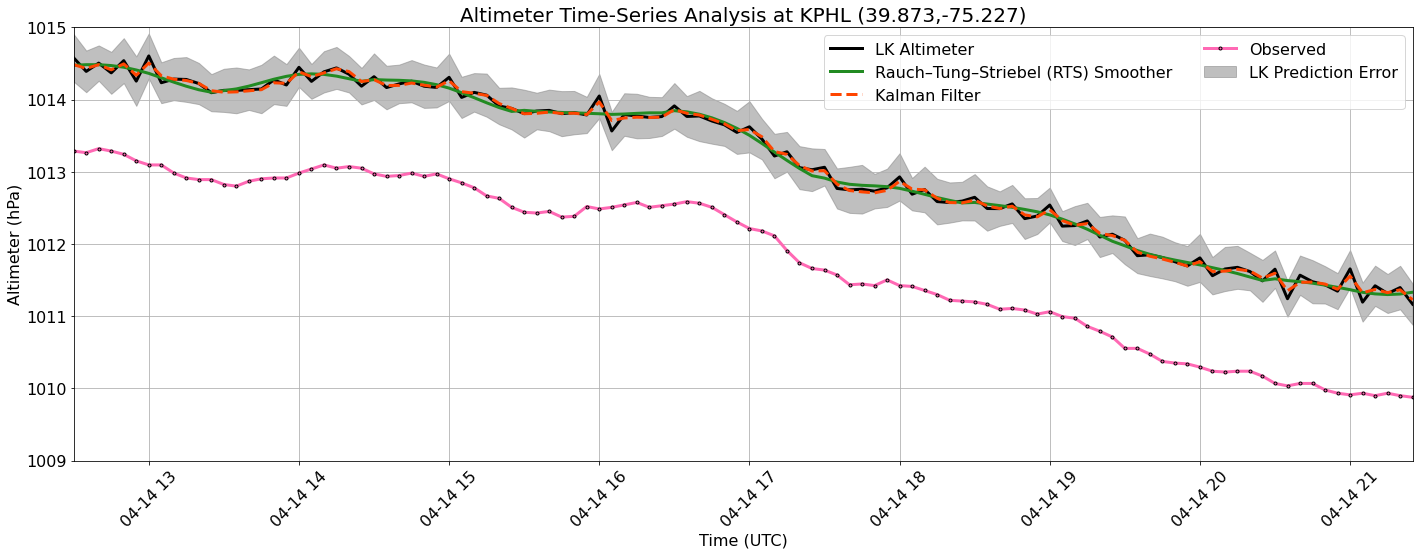

LK MAE: 0.2331760096779255
RTS MAE: 0.21378600092620453
-----------------
LK RMSE: 0.2633577826078851
RTS RMSE: 0.23150728038784402


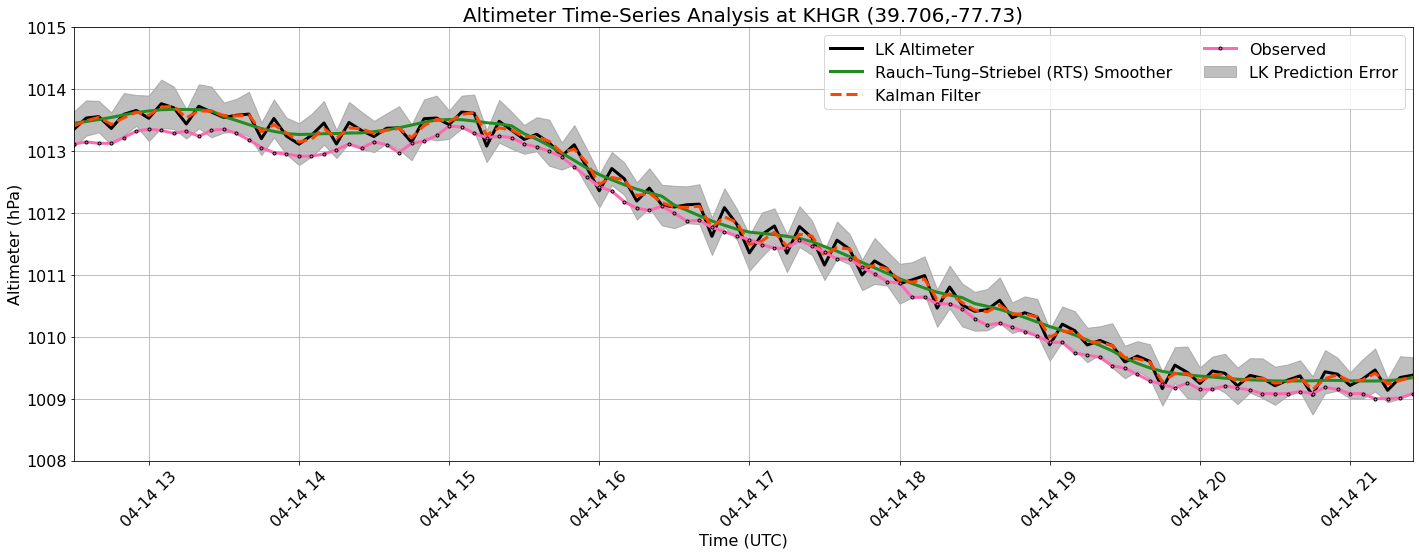

LK MAE: 0.574054694718265
RTS MAE: 1.1705682841816776
-----------------
LK RMSE: 0.6255582922183192
RTS RMSE: 1.1825423068215388


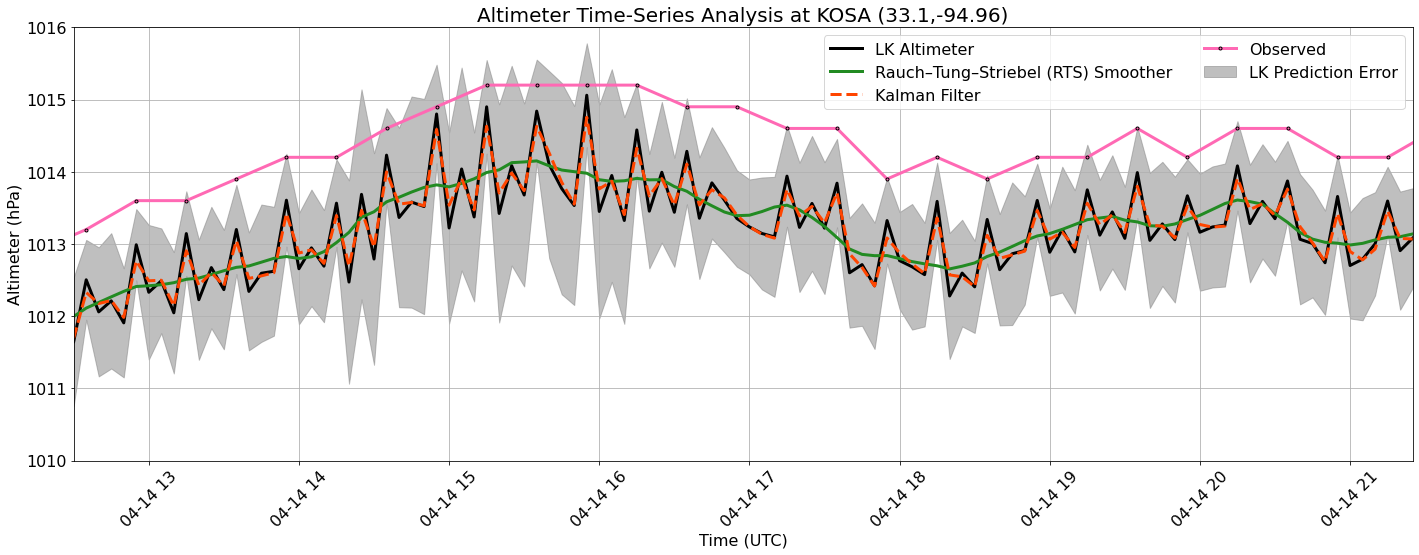

In [6]:
#Perform time-series analysis over full (10-h) analysis period demonstrating the application of a sliding window Kalman smoother on MADIS pressure anlayses.

#Urban Site
smooth_ts_plot('KPHL')

#Suburban Site
smooth_ts_plot('KHGR')

#Rural Site
smooth_ts_plot("KOSA")

As in (2) the effects of variable observation density are clear in the LatticeKrig time-series (black line). Kalman smoothing results in a pressure time-series that is temporally consistent with the observed pressure time-series. Kalman smoothing generally has little impact on the absolute accuracy of the analysis. This is not the case for the relative accuracy, which is important when evaluating pressure change or band-pass filtered pressure perturbations.

LK MAE: 0.09554260237275705
RTS MAE: 0.07089620573799177
-----------------
LK RMSE: 0.11939445140995437
RTS RMSE: 0.0836019924258798


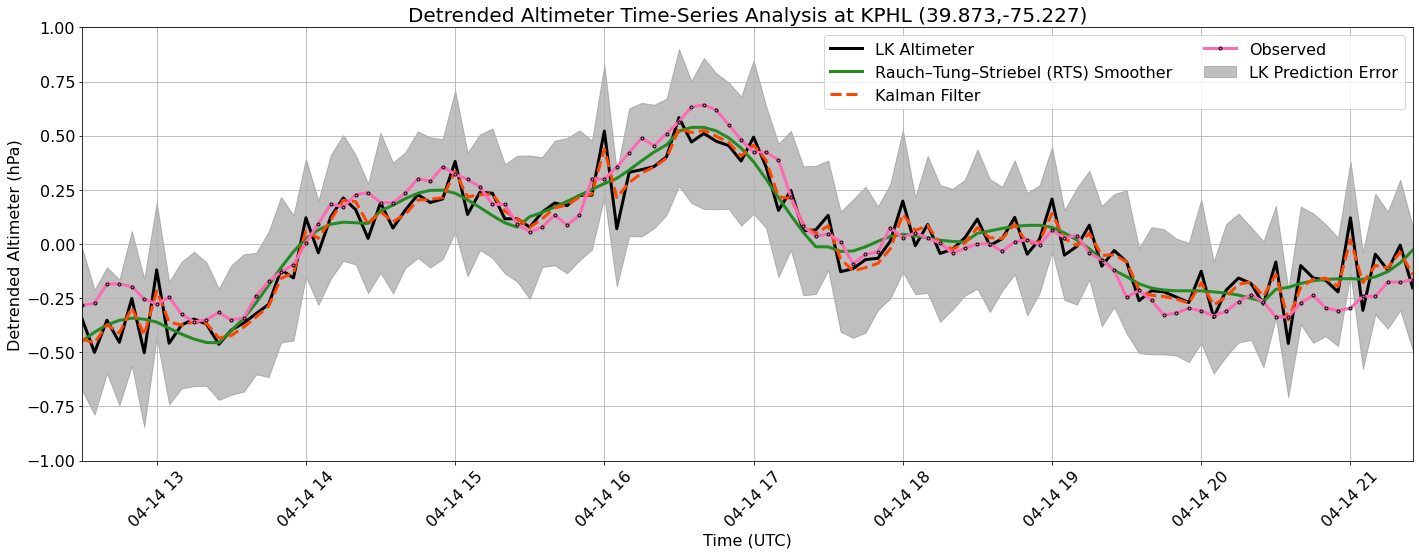

LK MAE: 0.18490191481132423
RTS MAE: 0.15830096923242032
-----------------
LK RMSE: 0.22099613566461043
RTS RMSE: 0.1775701918046713


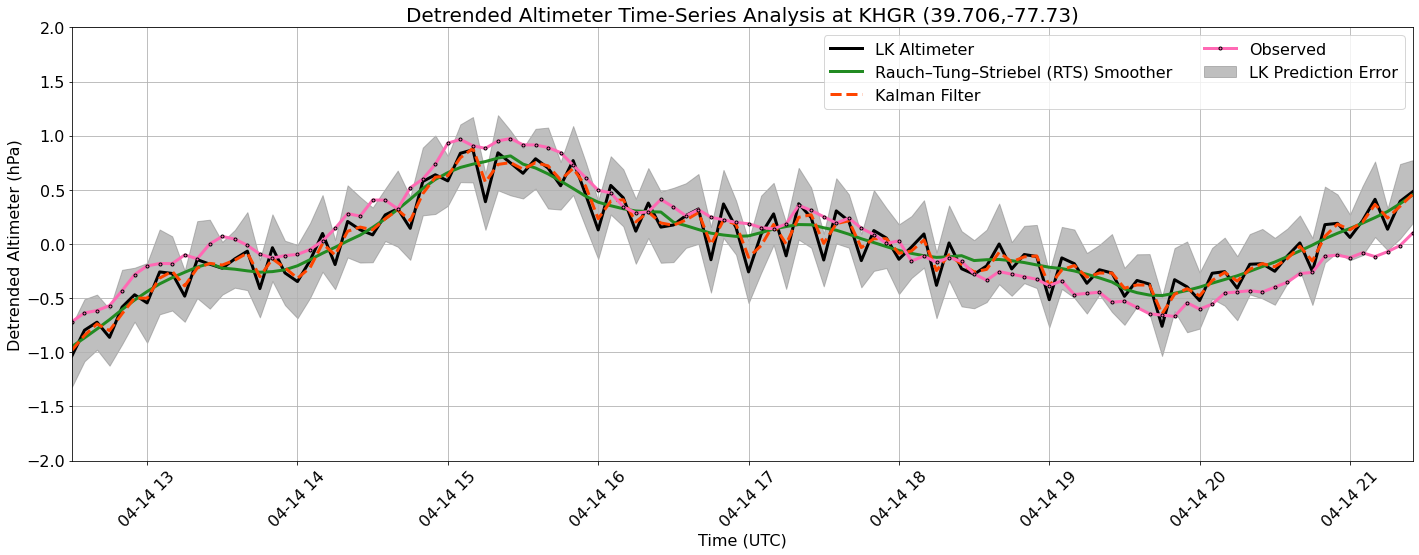

LK MAE: 0.5950955386407865
RTS MAE: 0.15763416616252252
-----------------
LK RMSE: 0.618211373793097
RTS RMSE: 0.19387669377905178


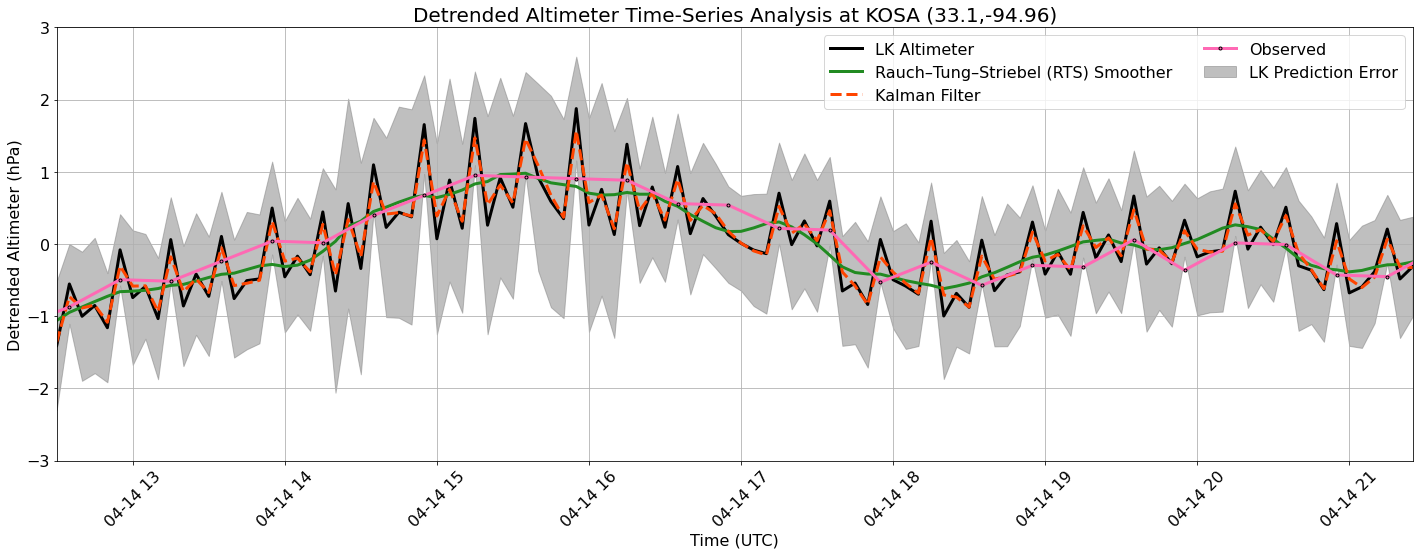

In [7]:
#Performed detrended time-series analysis over full (10-h) analysis period

#Urban
smooth_ts_plot('KPHL',True)

#Suburban/Exurban
smooth_ts_plot('KHGR',True)

#Rural
smooth_ts_plot("KOSA",True)

When time-series are detrended, the benefits of Kalman smoothing are clear. The smoothed time-series are much more consistent with the observations indicating that spatio-temporal kriging analyses (generated suing LatticeKrig and an RTS smoother) can accurately capture changes/perturbations in pressure time-series. This is in contrast to spatial kriging alone which, due to variable observation frequency, cannot adequetly capture variations in pressure due to noise. Thus, to examine pressure perturbations (e.g. mesocale pressure features), Kalman smoothing is necessary to ensure temporally continuity between 5-min pressure analyses.